In [1]:
# Using data file from COVID19_line_list_data.csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, roc_curve, make_scorer

In [2]:
# Convert covid line list data to data frame
data = pd.read_csv('../COVID19_line_list_data.csv')

# clean age data
data = data.dropna(axis='index', subset=['age'])

In [3]:
# Extract age and death data from the data frame
age_data = np.array(data['age'])
death_data = np.array(data['death'])

In [4]:
# convert death_data to just 0's and 1's
def death_conversion(x):
    if x=='0':
        return 0
    else:
        return 1
    
death_data = np.array([death_conversion(x) for x in death_data])

In [5]:
# perform logistic regression on the age vs. death

# initialize logistic regression class
log_reg = LogisticRegression()

# convert age_data to proper shape
x_data = age_data.reshape(-1,1)

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, death_data)

# fit logistic regression model to training data
log_reg.fit(x_train, y_train)

# predict death data based on logistic regression model
y_predicted = log_reg.predict(x_test)

# determine accuracy of model
accuracy_score(y_test, y_predicted);

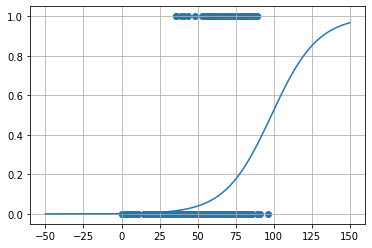

In [6]:
# create curve for the tested logistic regression data

# create logistic function
def logistic_function(x, a, b):
    return (1/(1+np.exp(-(a+b*x))))

# find a and b parameters
a = log_reg.intercept_[0]
b = log_reg.coef_[0,0]

# get curve values
x_curve = np.linspace(-50,150,200)
y_curve = logistic_function(x_curve, a, b)

# plot roc curve
plt.plot(x_curve, y_curve)

# plot original data points
plt.scatter(age_data, death_data)

# plot formatting
plt.grid()

In [7]:
# create roc curve

# get probabilities from model
probabilities = log_reg.predict_proba(x_test)[:,1]

# get roc parameters
FPR, TPR, THRESHOLDS = roc_curve(y_test, probabilities)

# plot roc curve
plt.plot(FPR,TPR, c='red', label="Logistic Regression")

# plot 45 degree line
plt.plot([0,1],[0,1], c='k', ls='--', label="45 Degree Line")

# plot formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.legend()
plt.gcf().set_size_inches(6,6)
plt.show()

In [8]:
# repeat the train test split at least 10 times and observe the accuracy

# list of colors for roc graph
colors = [
    'r','g','b','c','m','y',
    'tab:blue','tab:orange','tab:green',
    'tab:red','tab:purple','tab:brown',
    'tab:pink','tab:gray','tab:olive',
    'tab:cyan','salmon','peru','palegreen',
    'magenta'
]

# define function to run train test split
def log_regression_with_plot(x,y, i):
    # create new logistic regression class
    LR = LogisticRegression()
    
    # reshape x data
    x_data = x.reshape(-1,1)
    
    # split into train and test
    x_tr, x_ts, y_tr, y_ts = train_test_split(x_data, y)
    
    # fit data into log regression model
    LR.fit(x_tr, y_tr)
    
    # use trained model to predict y values
    y_pre = LR.predict(x_ts)
    
    # determine accuracy of model
    accuracy = accuracy_score(y_ts, y_pre)
    
    # get probabilites for roc curve
    probabilities = LR.predict_proba(x_ts)[:,1]
    
    # get roc parameters
    fpr, tpr, thresholds = roc_curve(y_ts, probabilities)
    
    # plot roc curve
    plt.plot(fpr,tpr, c=colors[i])
    
    return accuracy

# initialize accuracy array
reg_split_accuracies = []

# generate roc curves and log reg accuracies
for i in range(10):
    reg_split_accuracies.append(log_regression_with_plot(age_data,death_data, i))

# convert accuracies to numpy array
np_accuracies = np.array(reg_split_accuracies)
    
# plot 45 degree line
plt.plot([0,1],[0,1], c='k', ls='--')

# plot formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.title("COVID-19 First 1000 Cases: Age vs. Survival\n20 Train/Test Splits")
plt.gcf().set_size_inches(6,6)
plt.show()

In [9]:
# leave out 1 cross validation and use 10 more splits

accuracy_scorer = make_scorer(accuracy_score)

cross_val_accuracies = cross_val_score(LogisticRegression(), x_data, death_data, scoring=accuracy_scorer, cv=10)

cross_val_accuracies.mean()

0.9276330532212885

In [10]:
# Use KFold splits to evaluate Logistic Regression model

# initialze accuracies array
kf_accuracies = []

# initialize KFold object with 10 splits
kf = KFold(n_splits=10)

# loop over each iteration of splits and fit model then calculate
# accuracy of that iteration
for tr_idx, ts_idx in kf.split(x_data, death_data):
    LR = LogisticRegression()
    
    x_tr = x_data[tr_idx]
    x_ts = x_data[ts_idx]
    y_tr = death_data[tr_idx]
    y_ts = death_data[ts_idx]
    
    LR.fit(x_tr, y_tr)
    
    y_pre = LR.predict(x_ts)
    
    kf_accuracies.append(accuracy_score(y_ts, y_pre))
    
np_kf_accuracies = np.array(kf_accuracies)

In [11]:
# Visualize Accuracies

# Train test split accuracies
plt.scatter(np.linspace(1,10,10), np_accuracies, label="Train Test Accuracies")
plt.plot([1,10],[np_accuracies.mean(),np_accuracies.mean()], label="Train Test Accuracy Mean")

# Cross Validation Accuracies
plt.scatter(np.linspace(1,10,10), cross_val_accuracies, c='red', label="Cross Validation Accuracies")
plt.plot([1,10],[cross_val_accuracies.mean(), cross_val_accuracies.mean()], c='red', ls='-.', label="Cross Validation Accuracy Mean")

# KFold Accuracies
plt.scatter(np.linspace(1,10,10), np_kf_accuracies, c='green', label="KFold Accuracies")
plt.plot([1,10], [np_kf_accuracies.mean(),np_kf_accuracies.mean()], c='green', ls='--', label="KFold Accuracy Mean")

# Plot formatting
plt.legend()
plt.xlabel("Iteration Number")
plt.ylabel("Accuracy")
plt.ylim([0.875,1.025])
plt.grid()
plt.gcf().set_size_inches(8,8)
plt.show()